In [40]:
import jax
import jax.numpy as jnp

jax.config.update('jax_enable_x64', True)

import astropy.units as u
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla
from astropy.coordinates import EarthLocation
from astropy.time import Time
from pathlib import Path

import mistsim as ms

%matplotlib widget

In [7]:
DATA_DIR = Path("/home/christian/Documents/research/MIST/mistsim/notebooks/data/")

# beam
d = np.load(DATA_DIR / Path("beam.npz"))
freqs = d["freqs"]
gain = d["gain"]
theta = d["theta"]
horizon = theta <= 80
print(gain.shape, horizon.shape)

# sky
d = np.load(DATA_DIR / Path("haslam_galactic.npz"))
haslam = d["m"]
assert np.allclose(freqs, d["freqs"])  # check freqs match
print(haslam.shape)

(86, 181, 360) (181,)
(86, 196608)


## Mapmaking

We want to write our measurement in the form
$$\mathbf{d} = \mathbf{A} \mathbf{x} + \mathbf{n},$$
where $\mathbf{d}$ is the measured data (waterfall), $\mathbf{x}$ represents the sky, $\mathbf{n}$ represents the noise, and $\mathbf{A}$ is the "design matrix" that captures the instrument response (a combination of the beam model and the rotations).

Once we have that, we can estimate the sky model from the data with Wiener filtering:
$$\mathbf{\hat{x}} = \mathbf{W} \mathbf{d},$$ where the filter matrix is
$$\mathbf{W} = \mathbf{S}\mathbf{A^T} \left(\mathbf{A}\mathbf{S}\mathbf{A^T} + \mathbf{N} \right)^{-1}$$

with a noise covariance matrix of $\mathbf{N}$ and map prior of $\mathbf{S}$.


## Simulation details

We do one frequency at a time first, so $\mathbf{x}$ is a 1d-vector of the Haslam map at a specific frequency.

While it is possible to write down the explicit form of $\mathbf{A}$, we use a trick using scipy.sparse.linalg.LinearOperator which lets us define the linear operator in terms of our mistsim simulation functions.

# Step 1: Define the linear operator and do the forward transform

In [22]:
# this is the frequency of the simulation
FREQ_IX = -1
sim_freq = freqs[FREQ_IX]
print(f"Simulation frequency = {sim_freq:.0f} MHz")

# beam and sky at the frequency, need to add a dimension for broadcating
g = gain[FREQ_IX]
g = g[None]  # add back freq axis
print(g.shape)

beam = ms.Beam(g, sim_freq, sampling="mwss", horizon=horizon[:, None])

# this is the x vector!
sky_map = haslam[FREQ_IX]

Simulation frequency = 125 MHz
(1, 181, 360)


In [46]:
# forward sim params
tstart = Time("2026-02-25 12:27")
tend = tstart + 1*u.sday  # one sidereal day
times = cro.utils.time_array(t_start=tstart, t_end=tend, N_times=240)

lon = -90.74750
lat = 79.41833
alt = 150
lmax = 50

def forward(sky_map):
    """
    Wrap forward sim in one function
    This is the A@x operation

    Parameters
    ----------
    sky_map : 1d vector of the sky map in galactic
    Shape should be (npix,) where npix is the number of pixels in the map
    
    """
    sky_map = sky_map[None]  # add back freq axis
    sky = ms.Sky(sky_map, sim_freq, sampling="healpix", coord="galactic")
    sim = ms.Simulator(
        beam,
        sky,
        times.jd,
        sim_freq,
        lon,
        lat,
        alt=alt,
        lmax=lmax,
        Tgnd=0,
    )
    return sim.sim()

In [47]:
y = forward(sky_map)

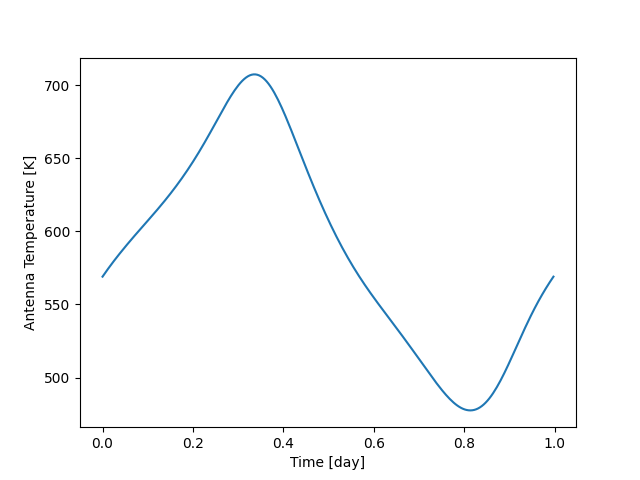

In [48]:
plt.figure()
plt.plot(times.jd-times.jd[0], y)
plt.xlabel("Time [day]")
plt.ylabel("Antenna Temperature [K]")
plt.show()

In [49]:
# to define the oeprator we also need the A^T operation
x_dummy = jnp.zeros(len(sky_map), dtype=jnp.float64)
transpose_fn = jax.linear_transpose(forward, x_dummy)

def matvec(v):
    out = forward(v)
    return np.asarray(out)

def rmatvec(v):
    out = transpose_fn(v)[0]
    return np.asarray(out)


# shape must match y = Ax
shape = (len(times), len(sky_map))
A = sla.LinearOperator(shape, matvec=matvec, rmatvec=rmatvec, dtype=np.float64)

In [63]:
# check that A works like forward
y2 = A@sky_map
print(np.allclose(y[:, 0], y2))

True


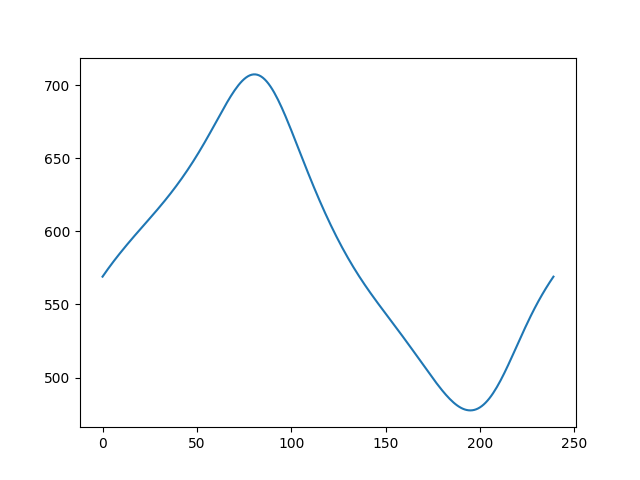

In [68]:
plt.figure()
plt.plot(y2)
plt.show()

## Step 2: Define N and S

In [67]:
# noise: radiometer
sigma = y / np.sqrt(1e6)
N = np.diag(sigma**2)

S = 

Array([[0.56902137],
       [0.57089407],
       [0.57272575],
       [0.57451986],
       [0.57627964],
       [0.57800806],
       [0.57970783],
       [0.58138132],
       [0.58303063],
       [0.5846576 ],
       [0.58626386],
       [0.58785085],
       [0.58941991],
       [0.5909723 ],
       [0.59250928],
       [0.59403214],
       [0.59554225],
       [0.59704106],
       [0.59853015],
       [0.60001123],
       [0.60148611],
       [0.60295673],
       [0.60442508],
       [0.60589326],
       [0.60736337],
       [0.60883753],
       [0.61031786],
       [0.61180642],
       [0.61330522],
       [0.61481619],
       [0.61634116],
       [0.61788189],
       [0.61944002],
       [0.6210171 ],
       [0.62261459],
       [0.6242339 ],
       [0.62587634],
       [0.62754319],
       [0.62923568],
       [0.63095501],
       [0.63270236],
       [0.63447886],
       [0.63628564],
       [0.63812376],
       [0.63999425],
       [0.64189805],
       [0.64383603],
       [0.645